# **Detecting FAUs by cropping relevant part of the face and using binary SVM classifiers**

conda env- detect_face

### Contents
*initial parts copied from detectFaceAndLandmarks.ipynb*
1.  **Functions to detect face and landmarks**
2.  ** **
3.  ** **
4.  ** **

** **

Importing libraries

In [1]:
import sys
import os
import random
import glob
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tqdm

**1. Detecting face and visualising landmarks**

In [3]:
args={"shape_predictor":"shape_predictor_68_face_landmarks.dat"}

In [4]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(args["shape_predictor"])

Function to detect faces and save in a txt file{image_name_landmarks1.txt} after detector and predictor are defined

In [5]:
def detectFace(impath):
    # load the input image, resize it, and convert it to grayscale
    image = cv2.imread(impath)
#     image = imutils.resize(image, width=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # detect faces in the grayscale image
    rects = detector(gray, 1)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
#         print(shape.shape)
        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 10)
        # show the face number
        cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        basePath=impath.split('.')[0]
#         uncomment lines to write the landmarks to a text file
        lmpath=basePath+"_landmarks"+str(i+1)+".txt"
        text_file = open(lmpath, "w")
        for (x, y) in shape:
#             print x,y
            cv2.circle(image, (x, y), 10, (0, 0, 255), -1)
            text_file.write(str(x)+' '+str(y)+'\n')
        text_file.close()
        
    # cv2.imshow("im", image)
    # cv2.waitKey(1000)
#     print 'These are the detected faces and the landmarks, which have been written to : ', lmpath
#     print imageTouse.shape,
#     print 'landmarks written to: ', lmpath
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
#         plt.imshow(image)
    return lmpath

'/home/amogh/cmu/notebooks/face_landmarks1.txt'

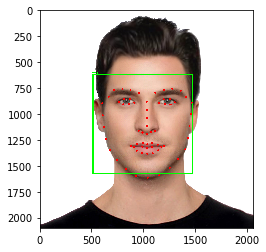

In [6]:
sample_image_path='/home/amogh/cmu/notebooks/face.jpg'
detectFace(sample_image_path)

## Cropping and aligning face

#### Helper functions: (see details in *tryAlignmentWarping.ipynb*)

In [7]:
# Read points from text files in directory
def readPoints(path) :
    pointsArray = [];
    points = [];   
#     print(path)
    with open(path) as file :
        for line in file :
            x, y = line.split()
            points.append((int(float(x)), int(float(y))))
    pointsArray.append(points)
    return pointsArray;

# Read all jpg images in folder.
def readImages(path) :
    imagesArray = [];
    img = cv2.imread(path);
    img = np.float32(img)/255.0;
    imagesArray.append(img);
    return imagesArray;
                
# Compute similarity transform given two sets of two points, OpenCV requires 3 pairs of corresponding points, we are faking the third one.
def similarityTransform(inPoints, outPoints) :
    s60 = math.sin(60*math.pi/180);
    c60 = math.cos(60*math.pi/180);  
  
    inPts = np.copy(inPoints).tolist();
    outPts = np.copy(outPoints).tolist();
    
    xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0];
    yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1];
    
    inPts.append([np.int(xin), np.int(yin)]);
    
    xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0];
    yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1];
    
    outPts.append([np.int(xout), np.int(yout)]);
    
    tform = cv2.estimateRigidTransform(np.array([inPts]), np.array([outPts]), False);
    
    return tform;

#### Function to align image

The code is in such a form so that refactoring allows calculating average landmarks for multiple images

In [8]:
def alignAndcrop(img_abs_path, landmark_abs_path):
    # Dimensions of output image
    w = 112;
    h = 112;
    landmark_path=landmark_abs_path
    allPoints = readPoints(landmark_path);
    images = readImages(img_abs_path);
    # Eye corners
    eyecornerDst = [ (np.int(0.3 * w ), np.int(h / 3)), (np.int(0.7 * w ), np.int(h / 3)) ];
    imagesNorm = [];
    pointsNorm = [];
#     print allPoints[0]
    # Add boundary points for delaunay triangulation
    boundaryPts = np.array([(0,0), (w/2,0), (w-1,0), (w-1,h/2), ( w-1, h-1 ), ( w/2, h-1 ), (0, h-1), (0,h/2) ]);
    n = len(allPoints[0]);
    numImages = len(images)
    for i in xrange(0, numImages):
        points1 = allPoints[i];
        # Corners of the eye in input image
        eyecornerSrc  = [ allPoints[i][36], allPoints[i][45] ] ;
        # Compute similarity transform
        tform = similarityTransform(eyecornerSrc, eyecornerDst);
        # Apply similarity transformation
        img = cv2.warpAffine(images[i], tform, (w,h));
#         print("debug im type shape max mean min ", img.dtype,img.shape,np.max(img),np.mean(img),np.min(img))
#         plt.imshow(img)
        # Apply similarity transform on points
        points2 = np.reshape(np.array(points1), (68,1,2));        
        points = cv2.transform(points2, tform);
        points = np.float32(np.reshape(points, (68, 2)));
        pointsNorm.append(points);
        imagesNorm.append(img);
#     print (pointsNorm[0])
#     plt.imshow(imagesNorm[0]) 
    # Output image
    output=imagesNorm[0]
#     for (x, y) in pointsNorm[0][]:
# #             print x,y
#             cv2.circle(output, (x, y), 2, (0, 0, 255), -1)
    writeToFile=False
    if writeToFile==True:
        pass
#         cv2.imwrite('cropped.bmp',output*255)
#     cv2.imshow('image', output)
#     cv2.waitKey(0)
    return output,pointsNorm[0]

In [9]:
def detectAndaligncrop(impath):
    lmpath=detectFace(impath)
    finalimage,finalpoints=alignAndcrop(impath,lmpath)
#     print 'final cropped image: ', finalimage.shape
#     cv2.imshow(finalimage)
#     cv2.waitKey(5000)
#     print("debug2 im type shape max mean min ", finalimage.dtype,finalimage.shape,np.max(finalimage),np.mean(finalimage),np.min(finalimage))
    rgb_image=cv2.cvtColor(finalimage,cv2.COLOR_BGR2RGB)
#     print("debug3 im type shape max mean min ", rgb_image.dtype,rgb_image.shape,np.max(rgb_image),np.mean(rgb_image),np.min(rgb_image))
    plt.imshow(rgb_image)
    return rgb_image,finalpoints

## Testing preprocessing on sample images

In [10]:
# imageTouse='/media/amogh/Stuff/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S999/003/S999_003_00000055.png'
# imageTouse='/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN013/001.jpeg'
# imageTouse='/home/amogh/cmu/dataset/BP4D/BP4D-training/F001/T1/2440.jpg' #BP4D images
imageTouse="files_may20/1.jpeg" #DISFA sample images
# imageTouse='/media/amogh/OS/Users/AMOGH GUPTA/Desktop/CMU/Face Alignment/FaceAverage/presidents/barak-obama.jpg'

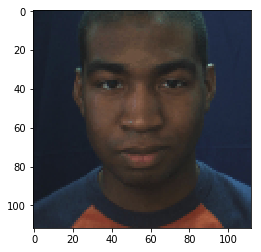

In [11]:
sample_alignedAndCropped,landmarkPoints=detectAndaligncrop(imageTouse)

In [12]:
np.max(sample_alignedAndCropped)

0.7217448

Cropping relevant parts of the face to detect an FAU

In [13]:
sample_im=cv2.imread('/home/amogh/cmu/notebooks/files_may20/facial-au-regions.png')

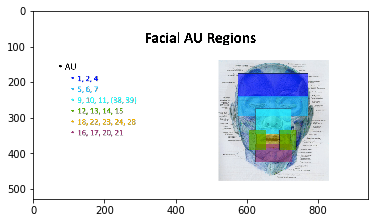

In [14]:
plt.imshow(sample_im)

Action units required for educationally relevant emotions- 1,2,4,5,7,12,43,25,26,

Frustration

    1 - Inner Brow Raise
    2 - Outer Brow Raise

Confusion

    4 - Brow Lowerer
    7 - Lid Tightener

Boredum

    43 - Eye Closure

Surprise

    1 - Inner Brow Raiser
    2 - Outer Brow Raiser
    5 - Upper Lid Raiser
    26 - Jaw Drop

Delight

    7 - Lid Tightener
    12 - Lip Corner Puller
    25 - Lips Part
    26 - Jaw Drop


#### Preprocessing code for the topmost region (FAU 1,2,4)

The top part of the eyes is FAUs 38,39,44,45; so let's take the average of the y coordinate of these

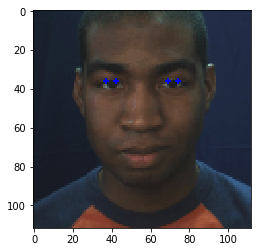

In [15]:
temp_fau_vis=sample_alignedAndCropped.copy()
for (x, y) in landmarkPoints[np.array([37,38,43,44])]:
    cv2.circle(temp_fau_vis, (x, y), 1, (0, 0, 255), -1)
plt.imshow(temp_fau_vis)

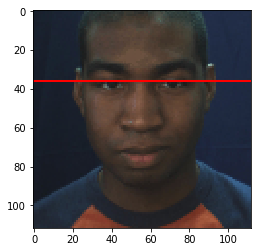

In [16]:
temp_line_vis=sample_alignedAndCropped.copy()
top_eyes=np.average([y for _,y in landmarkPoints[np.array([37,38,43,44])]])
cv2.line(temp_line_vis,(0,top_eyes),(temp_line_vis.shape[1],top_eyes),(255,0,0),1)
plt.imshow(temp_line_vis)

Cropping the part of the image above this line

In [17]:
int(top_eyes)

36

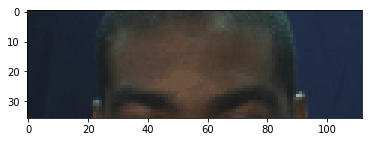

In [18]:
cropped_sample=sample_alignedAndCropped[0:int(top_eyes)]
plt.imshow(cropped_sample)

### Calculating HOG features

In [19]:
from skimage.feature import hog
from skimage import data,exposure

Some **debugging blocks** to analyse the shape and values of the images, datatype is integer when you read an image, it is float when we pass it through our function

In [70]:
fd1, hog_image1 = hog(gray_im, orientations=16, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled1 = exposure.rescale_intensity(hog_image1, in_range=(0, 0.02))
print("HOG vector dimension 1: ", fd1.shape)

fd2, hog_image2 = hog(gray_im, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled2 = exposure.rescale_intensity(hog_image2, in_range=(0, 0.02))
print("HOG vector dimension 2: ", fd2.shape)

fd3, hog_image3 = hog(gray_im, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled3 = exposure.rescale_intensity(hog_image3, in_range=(0, 0.02))
print("HOG vector dimension 3: " , fd3.shape)

fd4, hog_image4 = hog(gray_im, orientations=16, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled4 = exposure.rescale_intensity(hog_image4, in_range=(0, 0.02))
print("HOG vector dimension 4: ", fd4.shape)

('HOG vector dimension 1: ', (3136,))
('HOG vector dimension 2: ', (392,))
('HOG vector dimension 3: ', (1568,))
('HOG vector dimension 4: ', (12544,))


Text(0.5,1,'4')

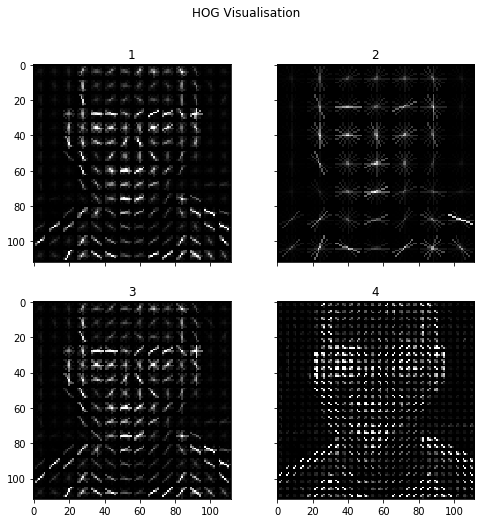

In [73]:
fig, axes=plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True)
fig.suptitle("HOG Visualisation")
axes[0,0].imshow(hog_image_rescaled1, cmap=plt.cm.gray)
axes[0,0].set_title('1')
axes[0,1].imshow(hog_image_rescaled2, cmap=plt.cm.gray)
axes[0,1].set_title('2')
axes[1,0].imshow(hog_image_rescaled3, cmap=plt.cm.gray)
axes[1,0].set_title('3')
axes[1,1].imshow(hog_image_rescaled4, cmap=plt.cm.gray)
axes[1,1].set_title('4')

Analysing cropped sample's HOG features

In [77]:
cropped_gray_im=cv2.cvtColor(cropped_sample,cv2.COLOR_RGB2GRAY)
fd1, hog_image1 = hog(cropped_gray_im, orientations=16, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled1 = exposure.rescale_intensity(hog_image1, in_range=(0, 0.02))
print("HOG vector dimension 1: ", fd1.shape)

fd2, hog_image2 = hog(cropped_gray_im, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled2 = exposure.rescale_intensity(hog_image2, in_range=(0, 0.02))
print("HOG vector dimension 2: ", fd2.shape)

fd3, hog_image3 = hog(cropped_gray_im, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled3 = exposure.rescale_intensity(hog_image3, in_range=(0, 0.02))
print("HOG vector dimension 3: " , fd3.shape)

fd4, hog_image4 = hog(cropped_gray_im, orientations=16, pixels_per_cell=(4, 4),
                    cells_per_block=(1, 1), visualise=True)
hog_image_rescaled4 = exposure.rescale_intensity(hog_image4, in_range=(0, 0.02))
print("HOG vector dimension 4: ", fd4.shape)

('HOG vector dimension 1: ', (896,))
('HOG vector dimension 2: ', (112,))
('HOG vector dimension 3: ', (448,))
('HOG vector dimension 4: ', (4032,))


Text(0.5,1,'4')

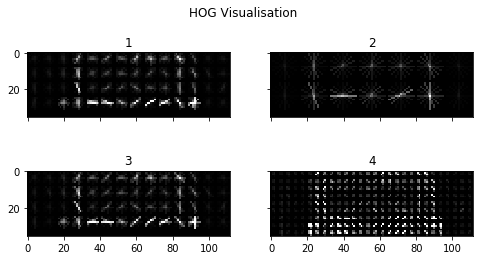

In [78]:
fig, axes=plt.subplots(2,2,figsize=(8,4),sharex=True,sharey=True)
fig.suptitle("HOG Visualisation")
axes[0,0].imshow(hog_image_rescaled1, cmap=plt.cm.gray)
axes[0,0].set_title('1')
axes[0,1].imshow(hog_image_rescaled2, cmap=plt.cm.gray)
axes[0,1].set_title('2')
axes[1,0].imshow(hog_image_rescaled3, cmap=plt.cm.gray)
axes[1,0].set_title('3')
axes[1,1].imshow(hog_image_rescaled4, cmap=plt.cm.gray)
axes[1,1].set_title('4')

## Dataset specific processing

### DISFA

In [112]:
import pandas as pd

In [166]:
DISFA_path='/media/amogh/Stuff/CMU/datasets/DISFA_data/'
DISFA_AU_path=DISFA_path+'ActionUnit_Labels/'
print(DISFA_AU_path)
Videos_right_path=DISFA_path+'Videos_RightCamera/'
print(Videos_right_path)

/media/amogh/Stuff/CMU/datasets/DISFA_data/ActionUnit_Labels/
/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/


Lets take 5 random samples frome each folder and take their max to get the max of eyebrow height. That would allow us to crop the image and get the HOG features

In [205]:
folder_list=glob.glob(Videos_right_path+"/*/")
folder_list

['/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN001/',
 '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN002/',
 '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN003/',
 '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN004/',
 '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN005/',
 '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN006/',
 '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN007/',
 '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN008/',
 '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN009/',
 '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN010/',
 '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN011/',
 '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN012/',
 '/m

In [187]:
random.choice(os.listdir(folder_list[0]))

'1137.jpeg'



  0%|          | 0/27 [00:00<?, ?it/s]

  4%|▎         | 1/27 [00:03<01:21,  3.14s/it]

  7%|▋         | 2/27 [00:09<01:55,  4.60s/it]

 11%|█         | 3/27 [00:14<01:57,  4.90s/it]

 15%|█▍        | 4/27 [00:18<01:46,  4.64s/it]

('error detected in', '/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN005/2229_landmarks1.txt')




 19%|█▊        | 5/27 [00:22<01:37,  4.43s/it]

 22%|██▏       | 6/27 [00:25<01:28,  4.22s/it]

 26%|██▌       | 7/27 [00:28<01:21,  4.06s/it]

 30%|██▉       | 8/27 [00:31<01:14,  3.93s/it]

 33%|███▎      | 9/27 [00:34<01:09,  3.86s/it]

 37%|███▋      | 10/27 [00:37<01:03,  3.76s/it]

 41%|████      | 11/27 [00:40<00:58,  3.67s/it]

 44%|████▍     | 12/27 [00:43<00:54,  3.61s/it]

 48%|████▊     | 13/27 [00:46<00:49,  3.56s/it]

 52%|█████▏    | 14/27 [00:49<00:45,  3.50s/it]

 56%|█████▌    | 15/27 [00:51<00:41,  3.45s/it]

 59%|█████▉    | 16/27 [00:54<00:37,  3.42s/it]

 63%|██████▎   | 17/27 [00:57<00:33,  3.38s/it]

 67%|██████▋   | 18/27 [01:00<00:30,  3.35s/it]

 70%|███████   | 19/27 [01:03<00:26,  3.32s/it]

 74%|███████▍  | 20/27 [01:05<00:23,  3.30s/it]

 78%|███████▊  | 21/27 [01:08<00:19,  3.27s/it]

 81%|████████▏ | 22/27 [01:11<00:16,  3.27s/it]

 85%|████████▌ | 23/27 [01:15<00:13,  3.26s/it]

 89%|████████▉ | 24/27 [01:18<00:09,  3.26s/it]

 93%|█████████▎| 25/27 

('top_list is: ', [36.75, 37.0, 36.0, 36.0, 36.0, 36.0, 37.0, 36.0, 36.75, 38.0, 35.5, 35.5, 37.0, 36.0, 36.0, 35.5, 37.0, 36.0, 36.25, 36.75, 36.0, 36.25, 36.0, 37.0, 36.5, 35.75, 36.0])
('max is: ', 38.0)


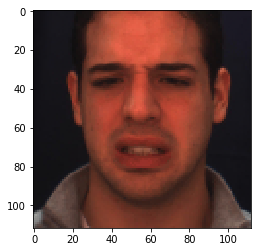

In [215]:
top_list=[]
error_list=[]
for fol in tqdm.tqdm(folder_list):
    random_sample=[]
    for i in range(5):
        random_image_name=random.choice(os.listdir(fol))
        try:
            random_alignedAndCropped,landmarkPoints=detectAndaligncrop(fol+random_image_name)
        except:
            error_list.append(fol+random_image_name)
            print("error detected in", fol+random_image_name)
            continue
        top_eyes=np.average([y for _,y in landmarkPoints[np.array([37,38,43,44])]])
        random_sample.append(top_eyes)
    top_list.append(max(random_sample))
print("top_list is: ", top_list)
print("max is: ", max(top_list))

So the max is about 38, to get the top part of the face, let's see what the cropped part looks like for each of the folders.

**Debug_section**

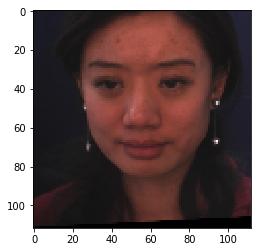

In [217]:
imageTouse="/media/amogh/Stuff/CMU/datasets/DISFA_data/Videos_RightCamera/RightVideoSN005/2229.jpeg" #DISFA sample images
im=cv2.imread(imageTouse)
plt.imshow(im)
sample_alignedAndCropped,landmarkPoints=detectAndaligncrop(imageTouse)

**Let's deal with FAU4**

Loading the counts - csv which contains the counts corresponding to every FAU in DISFA

In [114]:
df_counts=pd.read_csv('DISFA_FAUs/count_summary.csv')
df_counts

,Unnamed: 0,SN001,SN001_neg,SN002,SN002_neg,SN003,SN003_neg,SN004,SN004_neg,SN005,...,SN028,SN028_neg,SN029,SN029_neg,SN030,SN030_neg,SN031,SN031_neg,SN032,SN032_neg
0,count_FAU1,0.0,4845.0,152.0,4693.0,496.0,4349.0,1086.0,3759.0,26.0,...,0.0,4845.0,1008.0,3837.0,38.0,4807.0,23.0,4822.0,870.0,3975.0
1,count_FAU2,0.0,4845.0,166.0,4679.0,18.0,4827.0,1167.0,3678.0,4.0,...,23.0,4822.0,1949.0,2896.0,173.0,4672.0,30.0,4815.0,182.0,4663.0
2,count_FAU4,29.0,4816.0,10.0,4835.0,1752.0,3093.0,1546.0,3299.0,245.0,...,145.0,4700.0,2246.0,2599.0,405.0,4440.0,183.0,4662.0,1073.0,3772.0
3,count_FAU5,0.0,4845.0,9.0,4836.0,21.0,4824.0,53.0,4792.0,0.0,...,4.0,4841.0,20.0,4825.0,56.0,4789.0,0.0,4845.0,4.0,4841.0
4,count_FAU12,408.0,4437.0,273.0,4572.0,629.0,4216.0,765.0,4080.0,140.0,...,359.0,4486.0,627.0,4218.0,783.0,4062.0,1155.0,3690.0,608.0,4237.0
5,count_FAU25,249.0,4596.0,1071.0,3774.0,1777.0,3068.0,838.0,4007.0,741.0,...,1476.0,3369.0,383.0,4462.0,1552.0,3293.0,1809.0,3036.0,3067.0,1778.0
6,count_FAU26,186.0,4659.0,1680.0,3165.0,811.0,4034.0,71.0,4774.0,484.0,...,1585.0,3260.0,31.0,4814.0,253.0,4592.0,1475.0,3370.0,2153.0,2692.0


Seeing the number of positives for each FAU

In [115]:
df_counts.sum(1)-df_counts.filter(like="neg",axis=1).sum(1) #subtracting the sum of all columns containing "neg" from the sum of all columns(total count)

0     6506.0
1     5644.0
2    19933.0
3     1150.0
4    16851.0
5    36247.0
6    11533.0
dtype: float64

55